In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml



# 1 Préparation des données

In [19]:
dataset = fetch_openml('mnist_784', version=1)


In [20]:
dataset.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [21]:
y = dataset['target']
x = dataset['data']
x.shape
y.shape
#y = y.reshape(70000,1)
print(x.shape)
print(y.shape)

(70000, 784)
(70000,)


In [22]:
dataset['data']

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [23]:
#dataset['DESCR']

In [24]:
#dataset['details']

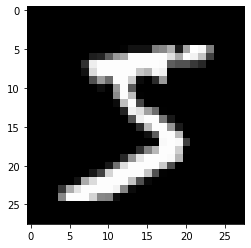

In [25]:
x1=x[0]# on crée une variable qui correspond à la première ligne
x1 = x1.reshape(28,28) #pour 28 lignes et 28 colonnes. On transforme le vecteurX[0] en image (28*28).

plt.imshow(x1, cmap="gray") 
plt.show() 



In [26]:
 
dataset["target"]
y[0]

'5'

In [27]:
#affichage du type des labels
y[0]

'5'

In [28]:
#transformation des labels en données numériques. On force y en type entier.
y = y.astype(np.uint8)


In [29]:
# Répartition des données.

#from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 1/7 , random_state = 42)

# 2 Apprentissage d’un classifieur binaire

**Apprentissage des données**

On s'intéresse dans un premier temps à la classification binaire, qui consiste à distinguer si un objet appartient 
ou non à une classe. Si oui, on dit que cette image est positive ; sinon, qu'elle est négative.
On partage nos données en une base de données d'apprentissage de 60 000 données et un ensemble de test de 10 000.


In [30]:
X_train, X_test, y_train, y_test = x[:60000], x[10000], y[:60000], y[10000]

Pour l'instant on essaye de se concentrer sur le chiffre 5 et on considère 2 classes la classe "5" 
et la classe non "5". On crée deux vecteurs cibles pour la classification binaitre.

In [31]:
y_train_5 = (y_train == 5)# vrai pour les 5 et faux pour le reste.
y_test_5 =(y_test == 5)

On choisit un classificateur et on l'entraîne sur la base d'apprentissage.
On va choisir un classificateur de Descente de Gradient Stochastique (SGD) qui a l'avantage de gérer 
des jeux de données volumineux. cette méthode permet également de traiter le jeu de données d'apprentissage 
de manière indépendante et gère tour à tour chaque observation des données d'apprentissage.

In [32]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier()


print(X_train.shape)
print(y_train_5.shape)
sgd_clf.fit(X_train, y_train_5)

(60000, 784)
(60000,)


SGDClassifier()

On peut utiliser ce modèle pour détecter les images représentant un 5.

In [33]:
sgd_clf.predict(X_train[[0]])

array([ True])

**Evaluation du modèle sur les données d'apprentissage**

**Taux de classification**

Pour évaluer notre modèle, on va utiliser la validation croisée en utilisant la méthode 3fold_cross_validation.
On va donc partager le jeu d'entraînement en 3 blocs, puis on effectue des prédictions et on évalue ces prédictions 
sur chaque bloc en utilisant un modèle entraîné sur le reste des blocs.

In [34]:
from sklearn.model_selection import cross_val_score
taux_classif = cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")
taux_classif

array([0.96365, 0.9463 , 0.964  ])

On obtient de très bon taux de classification compris entre 0.95 et 0.97.

In [35]:
taux_classif.mean()

0.9579833333333333

La moyenne du taux de classification se situe aux alentours de 96%.

**Utilisation d'un classifieur qui va classifier toutes les images comme des 'non 5'.**

In [36]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X), 1), dtype=bool)

On va Tester le classifieur en utilisant une validation croisée de type 3-fold cross-validation 
afin d'avoir le taux d'exactitude.

In [37]:
never_5_clf = Never5Classifier()
taux_classif_non5=cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")
taux_classif_non5

array([0.91125, 0.90855, 0.90915])

In [38]:
taux_classif_non5.mean()

0.90965

On obtient un taux de classification de plus de 90% sur les 3 folds et un taux de classification moyen de 91%. 
Peut-on vraiment en déduire que le modèle est performant? 
Ces bons résultats sont peut être dû au fait que les 5 sont finalement peu représentés et que quoi qu'il arrive
la probabilité de ne pas avoir de 5 sera vraie à 90%. 
On ne peut donc pas se fier à de bons résultats pour un classifieur, ce n'est pas un signe de bonne performance
du modèle mais plutôt le résultat d'une sous représentation des données à étudier dans le jeu de données.

**Matrice de confusion**

Pour évaluer la performance du modèle, on va étudier la matrice de confusion. Cela va nous permettre de voir si des 5
ont été mal classés. On va confronter les classes réelles et les classes predites gràce à la fonction 
cross_val_predict. Cette fonction fait une validation croisée à 3folds mais contrairement à la fonction 
cross_val_score, elle ne renvoie pas des scores d'évaluation mais des prédictions sur chaque blocs. On obtient
une prédiction cohérente sur chaque observation de la base d'entraînement.

In [41]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

On va utiliser la fonction confusion_matrix() pour obtenir la matrice de confusion en confrontant les classes réelles
que l'on étudie (y_train_ 5) et les classes prédites (y_train_pred)

In [42]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53742,   837],
       [ 1323,  4098]], dtype=int64)

Chaque ligne de la matrice de confusion correspond aux classes réelles et chaque colonne aux classes prédites.
La première ligne correspond à la classe négative, c'est à dire aux images "non 5". On a 53742 images qui ont été
classées correctement en "non 5". Ce sont les **vrais négatifs (TN)**, tandis que 837 images ont été classées à tort en 
"non 5". Ce sont les **faux positifs (FP)**. La deuxième ligne de la matrice correspond à la classe positive, c'est à 
dire aux images de 5. 1323 images de 5 ont été classées à tort en "non 5". Ce sont les **faux négatifs (FN).**
4098 images de 5 ont été correctement classées en images de 5. Ce sont les **vrais positifs (TP).**

**Précision et rappel**

- **La précision** permet d'étudier l'exactitude des prédictions positives. Sa formule est précision=(TP/(TP + FP))
- **Le rappel (ou sensibilité)** est le taux d'observation positives ayant été correctement détectées par 
le classificateur. La formule est: rappel= (TP/(TP+FN)).
    
Pour le calcul de la précision et du rappel, on va utiliser respectivement les fonctions (precision_score) 
et (recall_score).

In [45]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(y_train_5, y_train_pred)

0.8303951367781155

La probabilité qu'une image soit un 5 est de 83%**

In [46]:
recall_score(y_train_5, y_train_pred)

0.7559490868843387

le classifieur détecte que 75% des images sont des 5. Calculons le score F1 qui permet de combiner précision et 
rappel.

In [47]:
f1_score(y_train_5, y_train_pred)

0.791425260718424

il est logique de trouver un F1_score similaire car on a une précision et un rappel quasiment identique. 
Pour voir le compromis existant entre Rappel et précision, le SGDClassifier prend des décisions de classification.
Il va alors pour chaque observation, calculer un score basé sur une fonction de décision. Si ce score est supérieur
à un certain seuil, il affecte la donnée à la classe positive, sinon il l'affecte à la classe négative.

on souhaite ici avoir les scores des données d'apprentissage. On utilise cross_val__predict, mais au lieu d'avoir des 
prédictions, on souhaite avoir des scores de décision.

In [48]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function") 

Avec les scores obtenus, on va calculer la précision et le rappel pour tous les seuils possibles.

In [49]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)# thresholds correspond au seuil.


**courbe de précision et de rappel**

<function matplotlib.pyplot.show(*args, **kw)>

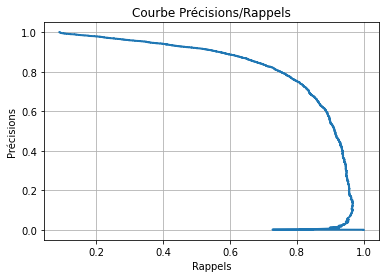

In [50]:
def plot_precision_recall(precisions, recalls, label=None):
    plt.plot(precisions, recalls, linewidth=2, label=label)
    plt.title("Courbe Précisions/Rappels")
    plt.xlabel("Rappels")
    plt.ylabel("Précisions")
plot_precision_recall(precisions, recalls)    
plt.grid()
plt.show

On constate que la précisions commence à chuter aux environs de 80% de rappel. Il faudrait choisir un compromis avant 
cette chûte , c'est à dire aux alentours d'un rappel de 60%.

**Courbe ROC**

La courbe ROC croise le taux de vrais positifs avec le taux de faux positifs. Le taux de faux positifs est
le pourcentage d'observations negatives qui sont incorrectement classées comme positives. Pour calculer ces 
taux on utilise la fonction roc_curve:

In [51]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve (y_train_5, y_scores)
fpr, tpr, thresholds

(array([0.        , 0.        , 0.        , ..., 0.99923047, 0.99923047,
        1.        ]),
 array([0.00000000e+00, 1.84467810e-04, 9.22339052e-04, ...,
        9.99815532e-01, 1.00000000e+00, 1.00000000e+00]),
 array([  38629.83485738,   38628.83485738,   29253.58575827, ...,
         -80288.52612407,  -80311.77531598, -115482.21469191]))

<function matplotlib.pyplot.show(*args, **kw)>

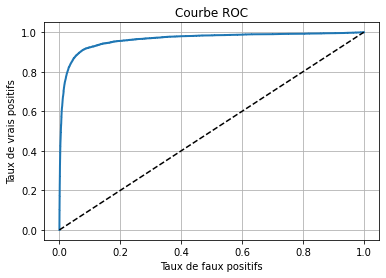

In [52]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0,1], 'k--')# pour une diagonale en pointillée
    plt.title("Courbe ROC")
    plt.xlabel("Taux de faux positifs")
    plt.ylabel("Taux de vrais positifs")
plot_roc_curve(fpr, tpr)    
plt.grid()
plt.show

On a ainsi l'évolution du taux de vrais positifs en fonction du taux de faux positifs. On retrouve une courbe qui est
similaire à la courbe précision/rappel.
de manière générale, on préférera la courbe précision/rappel si la classe positive est rare ou si on accorde 
plus d'importance aux faux positifs qu'aux faux négatifs. On utilisera la courbe ROC dans le cas contraire.



**Calcul AUC (Area Under the Curve)**

cet indicateur permet de comparer les classificateurs en mesurant l'aire sous la courbe.

In [53]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.964145736039187

On obtient une bonne performance du classificateur, mais est -il vraiment bon ou ce résultat est -il dû au fait qu'il
y a peu de positifs 5 par rapport aux négatifs( non5).

# 3 Apprentissage d’un classifieur multi-classes

**Apprentissage des données**

On va utiliser un classificateurs qui permet ici de clasifier plusieurs classes. On va utiliser un classificateur
de type SVM.
Ici on veut classer les dix classes (chiffres de 0 à 9)

In [62]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)


SVC()

In [63]:
#xt = x[0]
#xt.shape
#xt = xt.reshape(784, 1)
#xt.shape



In [64]:
xtot = sgd_clf.predict(x[0].reshape(1,784))


On entraîne le SVC sur le jeu d'entraînement en utilisant toutes les classes et pas seulement les classes 5. 
On utilise donc y_train du départ et non plus y_train_5.

In [65]:
tot_class_scores = svm_clf.decision_function(x[0].reshape(1,784))
tot_class_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

On obtient 10 scores (un score par classe). Le plus haut score correspond à la classe 5.

In [66]:
np.argmax(tot_class_scores)

5

In [67]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [68]:
svm_clf.classes_[5]

5

Quand un classificateur est entraîné, il range la liste des classes dans son attribut **classes_**, classées par valeur.
Or, ici l'index de la classe coreespond à la classe elle-même. La classe d'index 1 est la classe 1 et ainsi de suite.

**Évaluation du modèle d’apprentissage sur les données d’apprentissage**

**Taux de classification**

In [69]:
score_tot= cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

In [70]:
score_tot

array([0.88425, 0.87595, 0.87035])

In [71]:
score_tot.mean()

0.87685

on obtient un score compris entre 87 et 89% et un score moyen de 88%.
On regarde si on peut améliorer ce résultat en normalisant les données en entrée.

In [72]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")


C:\Users\utilisateur\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


array([0.899 , 0.8978, 0.9035])

On obtient un résultat encore meilleur en normalisant nos données.

**Matrice de confusion**

In [73]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

C:\Users\utilisateur\anaconda3\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:570: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn("Maximum number of iteration reached before "


array([[5596,    0,   21,    6,    9,   53,   37,    7,  193,    1],
       [   1, 6407,   38,   26,    4,   46,    4,    8,  196,   12],
       [  28,   28, 5273,  103,   72,   29,   65,   38,  312,   10],
       [  25,   18,  122, 5271,    2,  223,   27,   42,  330,   71],
       [  10,   15,   49,   10, 5233,   14,   38,   26,  279,  168],
       [  28,   16,   35,  180,   55, 4541,   74,   16,  412,   64],
       [  30,   16,   47,    3,   43,  100, 5559,    4,  115,    1],
       [  19,   12,   56,   33,   51,   16,    3, 5716,  144,  215],
       [  20,   63,   47,   95,    3,  131,   26,   11, 5406,   49],
       [  26,   20,   29,   68,  116,   42,    1,  181,  302, 5164]],
      dtype=int64)

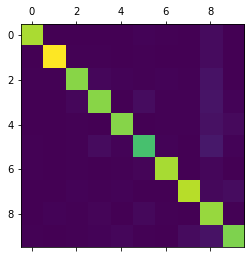

In [74]:
plt.matshow(conf_mx)
plt.show()

On obtient de bons résultats pour la matrice de confusion car la plupart des images se situent dans la diagonale
principale, ce qui signifie que la plupart des images ont bien été classées. La classe des 5 est plus sombre que 
pour les autres chiffres. Ceci peut s'expliquer par le fait que la classe des 5 est moins représentatives du jeu
de données ou que le classificateur ne donne pas d'aussi bons résultats sur la classe des 5 que pour les autres
classes.